<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session4_attemp2b/1_base_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skeleton code


### Import Libraries


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

### Dataset and creating train/ test split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader arguments and test/ train dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


### Data statistics

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


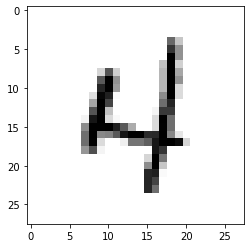

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

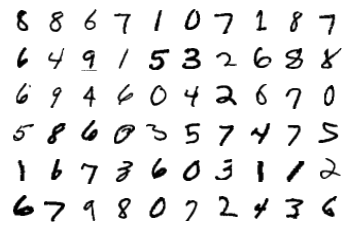

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

In [7]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )  # ip = 28 | op = 26 | RF = 

        # CONVOLUTION BLOCK 
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24)
        ) # ip = 26 | op = 24 | RF = 

        # TRANSITION BLOCK 
        self.transblock1 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=18, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
        ) # ip = 24 | op = 24 | RF = 
        self.pool1 = nn.MaxPool2d(2, 2) # ip = 24 | op = 12 | RF =

        # CONVOLUTION BLOCK 
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        ) # ip = 12 | op = 10 | RF = 

        # CONVOLUTION BLOCK 
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(18)
        ) # ip = 10 | op = 8 | RF =

        # CONVOLUTION BLOCK
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # ip = 8 | op = 6 | RF = 

        # GAP layer
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # ip = | op = | RF = 

        self.transblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # ip = 4 | op = 4 | RF = 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transblock1(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)
        x = self.transblock2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model parameters

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 24, 24, 24]           1,728
              ReLU-5           [-1, 24, 24, 24]               0
       BatchNorm2d-6           [-1, 24, 24, 24]              48
            Conv2d-7           [-1, 18, 24, 24]             432
              ReLU-8           [-1, 18, 24, 24]               0
         MaxPool2d-9           [-1, 18, 12, 12]               0
           Conv2d-10           [-1, 14, 10, 10]           2,268
             ReLU-11           [-1, 14, 10, 10]               0
      BatchNorm2d-12           [-1, 14, 10, 10]              28


### Training and testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

### Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.08345027267932892 Batch_id=937 Accuracy=93.65: 100%|██████████| 938/938 [01:14<00:00, 12.63it/s]



Test set: Average loss: 0.0774, Accuracy: 9782/10000 (97.82%)

EPOCH: 1


Loss=0.22893747687339783 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [01:06<00:00, 14.12it/s]



Test set: Average loss: 0.0464, Accuracy: 9848/10000 (98.48%)

EPOCH: 2


Loss=0.004915728699415922 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [01:08<00:00, 13.79it/s]



Test set: Average loss: 0.0320, Accuracy: 9891/10000 (98.91%)

EPOCH: 3


Loss=0.023531734943389893 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [01:05<00:00, 14.40it/s]



Test set: Average loss: 0.0356, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.0658065602183342 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [01:05<00:00, 14.33it/s]



Test set: Average loss: 0.0266, Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.0020961861591786146 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:05<00:00, 14.35it/s]



Test set: Average loss: 0.0245, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.008715582080185413 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [01:06<00:00, 14.03it/s]



Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.003746520262211561 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [01:05<00:00, 14.41it/s]



Test set: Average loss: 0.0287, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.011927139945328236 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [01:05<00:00, 14.37it/s]



Test set: Average loss: 0.0328, Accuracy: 9898/10000 (98.98%)

EPOCH: 9


Loss=0.00497573334723711 Batch_id=937 Accuracy=99.35: 100%|██████████| 938/938 [01:08<00:00, 13.74it/s]



Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.12585434317588806 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [01:08<00:00, 13.63it/s]



Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.01323669869452715 Batch_id=937 Accuracy=99.52: 100%|██████████| 938/938 [01:06<00:00, 14.19it/s]



Test set: Average loss: 0.0243, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.09440608322620392 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [01:05<00:00, 14.22it/s]



Test set: Average loss: 0.0254, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.02217291109263897 Batch_id=937 Accuracy=99.52: 100%|██████████| 938/938 [01:06<00:00, 14.20it/s]



Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.014433613047003746 Batch_id=937 Accuracy=99.56: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]



Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)



### Plotting

Text(0.5, 1.0, 'Test Accuracy')

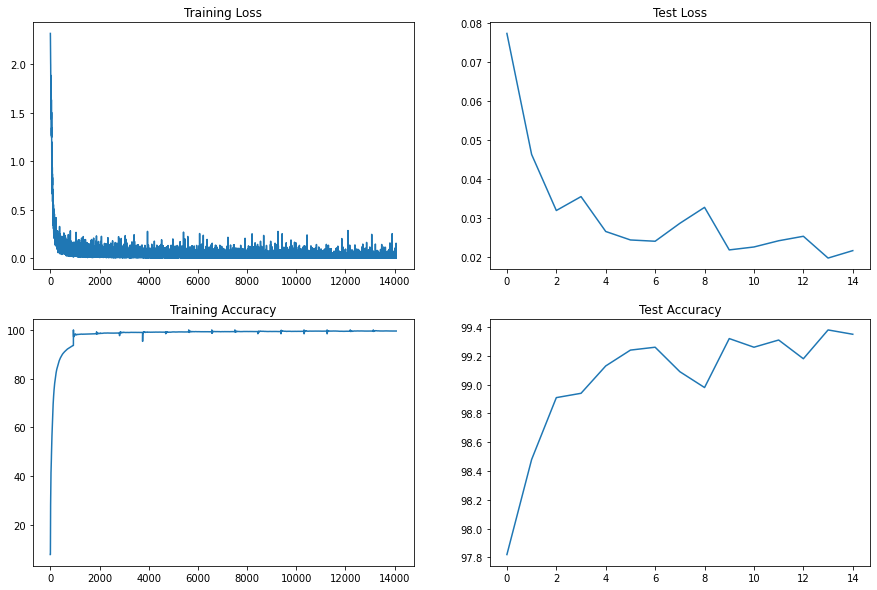

In [11]:
import numpy as np
fig, axs = plt.subplots(2,2,figsize=(15,10))
#train_losses=plt.plot(list(range(len(train_loss))),train_loss.cpu().detach().numpy(),color="r",label="Train "+typ)
#print (train_losses)
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")